# Predicting Rainfall
#### Alamgir Alam (45696020)
#### Jack Lewin (45257531)
#### Marcus Palio (45253552)
#### Max Grant (44910118)

## Aim of the project:
Our goals are to utilise both analysis and visualisation of the datasets to produce a robust report and model of the impact of the varying weather elements in predicting rainfall.

The datasets include daily readings of:
- Rainfall
- Minimum and Maximum Temperature
- Solar Exposure
- Wind Speed and Direction
- Air Pressure
- Humidity

Looking at this data for the past 10 years for the Sydney Observatory Hill weather station (station code: 066062), we are looking at how effective these factors are at predicting rainfall.



## Import Libraries to be used:

In [155]:
# import libraries
import pandas as pd
import datetime
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

## Import and manipulation of data:
Using four datasets from the Bureau of Meteorology (BOM), for readings of maximum temperature, minimum temperature, rainfall and solar exposure, they will be cleaned, before being merged and filling unavailable data from an existing dataset.

In [156]:
# import data
max_temp = pd.read_csv('Data/max_temp_daily.csv')
min_temp = pd.read_csv('Data/min_temp_daily.csv')
rainfall = pd.read_csv('Data/rainfall_daily.csv')
solar_exp = pd.read_csv('Data/solar_exposure_daily.csv')

#### A look at the data for maximum temperature:

In [157]:
max_temp.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,66062,1859,1,1,24.4,NaN,Y
1,IDCJAC0010,66062,1859,1,2,24.4,1.0,Y
2,IDCJAC0010,66062,1859,1,3,24.2,1.0,Y
3,IDCJAC0010,66062,1859,1,4,24.7,1.0,Y
4,IDCJAC0010,66062,1859,1,5,24.6,1.0,Y


### Cleaning the data:

#### Converting to datetime:
This allows for manipulation of the data based on the date of the weather recordings

In [158]:
# convert seperate Year, Month and Day columns to one datetime column
max_temp_date = pd.to_datetime(max_temp[['Year', 'Month', 'Day']])
min_temp_date = pd.to_datetime(min_temp[['Year', 'Month', 'Day']])
rainfall_date = pd.to_datetime(rainfall[['Year', 'Month', 'Day']])
solar_exp_date = pd.to_datetime(solar_exp[['Year', 'Month', 'Day']])
# add new datetime column to the data
max_temp['Date'] = max_temp_date
min_temp['Date'] = min_temp_date
rainfall['Date'] = rainfall_date
solar_exp['Date'] = solar_exp_date

#### Removing unnecessary columns from the data:
These columns are unnecessary in our analysis, and thus for simplicity will be removed

In [159]:
# remove unnecessary columns
max_temp1 = max_temp.drop(columns=['Product code', 'Bureau of Meteorology station number', 'Days of accumulation of maximum temperature', 'Year', 'Month', 'Day', 'Quality'])
min_temp1 = min_temp.drop(columns=['Product code', 'Bureau of Meteorology station number', 'Days of accumulation of minimum temperature', 'Year', 'Month', 'Day', 'Quality'])
rainfall1 = rainfall.drop(columns=['Product code', 'Bureau of Meteorology station number', 'Period over which rainfall was measured (days)', 'Year', 'Month', 'Day', 'Quality'])
solar_exp1 = solar_exp.drop(columns=['Product code', 'Bureau of Meteorology station number', 'Year', 'Month', 'Day'])

#### Restricting the data based on dates:
Before mid 2012, the Bureau of Meteorology didn't record all available weather readings. In particular, wind direction wasn't recorded on a daily basis until mid 2012, therefore to improve the accuracy and usefullness of the analysis the project will focus on data from 1/7/2012 to 25/6/2017.

In [160]:
# restrict dates from 2012-07-01 to 2017-06-25 -----------> (best recorded data is within these dates)
start_date = pd.to_datetime('2012-07-01')
end_date = pd.to_datetime('2017-06-25')
restricted_max_temp = max_temp1.loc[(max_temp1['Date'] >= start_date) & (max_temp1['Date'] <= end_date)]
restricted_min_temp = min_temp1.loc[(min_temp1['Date'] >= start_date) & (min_temp1['Date'] <= end_date)]
restricted_rainfall = rainfall1.loc[(rainfall1['Date'] >= start_date) & (rainfall1['Date'] <= end_date)]
restricted_solar_exp = solar_exp1.loc[(solar_exp1['Date'] >= start_date) & (solar_exp1['Date'] <= end_date)]

Now we index the four datasets on the date of the recording

In [161]:
# Set the new datetime column 'Date' as the index
max_temp_final = restricted_max_temp.set_index('Date')
min_temp_final = restricted_min_temp.set_index('Date')
rainfall_final = restricted_rainfall.set_index('Date')
solar_exp_final = restricted_solar_exp.set_index('Date')

Here is an example of the cleaned dataset for maximum temperature:

In [162]:
max_temp_final.head()

,Maximum temperature (Degree C)
Date,
2012-07-01,16.1
2012-07-02,16.8
2012-07-03,16.8
2012-07-04,16.2
2012-07-05,14.9


The other 3 datasets mirror this format and they are now ready to be merged based on the date of the recording

## Adding additional data from an existing dataset:
As alot of the BOM's datasets are unavailable we will utilise a pre-existing dataset to supplement the four datasets above.

In [163]:
# import kaggle dataset
weather_aus = pd.read_csv('Data/weatherAUS.csv')

## A look at the dataset:

In [164]:
weather_aus.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


The dataset contains readings for many citys around Australia, however we only want readings for Syndey, so we will create a new dataset that only contains weather readings for Sydney.

In [165]:
# create dataframe with only Locations containg "Sydney"
weather_syd = weather_aus[weather_aus['Location'].str.contains("Sydney")]
# remove "SydneyAirport"
weather_syd_only = weather_syd[~weather_syd['Location'].str.contains("SydneyAirport")]

Now we have reduced the dataset to contain only readings of weather in Sydney. Having a look at the new data we can see this.

In [166]:
weather_syd_only.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
29497,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,6.0,Yes
29498,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,6.6,Yes
29499,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,18.8,Yes
29500,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,77.4,Yes
29501,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,1.6,Yes


Now, in order to utilise this dataset with our existing four datasets, we will need to apply some further manipulation. We begin with converting the dates to datetime format:

In [167]:
weather_syd_only['Date'] = pd.to_datetime(weather_syd_only['Date'])

C:\Users\Mark\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now we can restrict the dataset to match the timeframe of our other data (1/7/2012 to 25/6/2017).

In [168]:
weather_syd_date_restricted = weather_syd_only.loc[(weather_syd_only['Date'] >= start_date)]

In [169]:
weather_syd_date_restricted.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
31076,2012-07-01,Sydney,9.9,16.1,0.0,3.0,5.9,WSW,44.0,W,...,28.0,1016.2,1013.4,6.0,2.0,10.4,15.8,No,0.0,No
31077,2012-07-02,Sydney,7.5,16.8,0.0,3.8,9.6,W,52.0,W,...,36.0,1016.0,1015.5,1.0,3.0,11.3,16.1,No,0.0,No
31078,2012-07-03,Sydney,7.7,16.8,0.0,2.8,9.5,NaN,NaN,W,...,40.0,1020.3,1018.1,1.0,5.0,9.6,15.8,No,0.0,No
31079,2012-07-04,Sydney,7.2,16.2,0.0,3.6,6.4,NaN,NaN,W,...,43.0,1024.6,1025.1,3.0,7.0,9.6,15.9,No,4.0,Yes
31080,2012-07-05,Sydney,8.7,14.9,4.0,2.6,4.5,SSW,44.0,W,...,72.0,1031.0,1030.1,5.0,7.0,10.7,13.6,Yes,19.0,Yes


In order to merge the datasets we need to set a common index between them. In the same fashion as with the previous four datasets, we set the index to the date

In [170]:
weather_syd = weather_syd_date_restricted.set_index('Date')

This has produced the following dataset:

In [171]:
weather_syd.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-01,Sydney,9.9,16.1,0.0,3.0,5.9,WSW,44.0,W,W,...,28.0,1016.2,1013.4,6.0,2.0,10.4,15.8,No,0.0,No
2012-07-02,Sydney,7.5,16.8,0.0,3.8,9.6,W,52.0,W,WSW,...,36.0,1016.0,1015.5,1.0,3.0,11.3,16.1,No,0.0,No
2012-07-03,Sydney,7.7,16.8,0.0,2.8,9.5,NaN,NaN,W,S,...,40.0,1020.3,1018.1,1.0,5.0,9.6,15.8,No,0.0,No
2012-07-04,Sydney,7.2,16.2,0.0,3.6,6.4,NaN,NaN,W,SSW,...,43.0,1024.6,1025.1,3.0,7.0,9.6,15.9,No,4.0,Yes
2012-07-05,Sydney,8.7,14.9,4.0,2.6,4.5,SSW,44.0,W,SSW,...,72.0,1031.0,1030.1,5.0,7.0,10.7,13.6,Yes,19.0,Yes


## Joining the datasets:
We can now join the 5 datasets to form 1 dataset:

In [172]:
# join all datasets
join1 = pd.concat([weather_syd, max_temp_final], axis = 1)
join2 = pd.concat([join1, min_temp_final], axis = 1)
join3 = pd.concat([join2, rainfall_final], axis = 1)
weather_syd2 = pd.concat([join3, solar_exp_final], axis = 1)

We now have one dataset with all our data:

In [173]:
weather_syd2.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Daily global solar exposure (MJ/m*m)
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-01,Sydney,9.9,16.1,0.0,3.0,5.9,WSW,44.0,W,W,...,2.0,10.4,15.8,No,0.0,No,16.1,9.9,0.0,7.3
2012-07-02,Sydney,7.5,16.8,0.0,3.8,9.6,W,52.0,W,WSW,...,3.0,11.3,16.1,No,0.0,No,16.8,7.5,0.0,9.4
2012-07-03,Sydney,7.7,16.8,0.0,2.8,9.5,NaN,NaN,W,S,...,5.0,9.6,15.8,No,0.0,No,16.8,7.7,0.0,9.9
2012-07-04,Sydney,7.2,16.2,0.0,3.6,6.4,NaN,NaN,W,SSW,...,7.0,9.6,15.9,No,4.0,Yes,16.2,7.2,0.0,9.4
2012-07-05,Sydney,8.7,14.9,4.0,2.6,4.5,SSW,44.0,W,SSW,...,7.0,10.7,13.6,Yes,19.0,Yes,14.9,8.7,4.0,6.7


However, looking at the dataset, there are still a few issues that must be fixed before we can begin analysis:

We begin by removing rows that contain any NaN values

In [174]:
weather_syd_dropna = weather_syd2.dropna()

Looking at the shapes of the datasets, we can see that we have dropped 170 daily readings because of missing values. This is the best approach as it provides a full dataset and doesnt detract enough readings to reduce the accuracy of our analysis.

In [175]:
print('With NaN values: ', weather_syd2.shape)
print('NaN values removed: ', weather_syd_dropna.shape)

With NaN values:  (1821, 27)
NaN values removed:  (1651, 27)


In order to conduct our analysis we need to change the categorical variables. In this dataset we have three categorical variables, 'WindGustDir', 'WindDir9am' and 'WindDir3pm'. 
<br>
To convert these variables we utilise pandas 'get_dummies', which converts categorical variables to dummy/indicator variables.

In [176]:
wind_gust_dir = pd.get_dummies(weather_syd_dropna['WindGustDir'], prefix = 'gust_dir')
wind_dir_9am = pd.get_dummies(weather_syd_dropna['WindDir9am'], prefix = '9am_wind_dir')
wind_dir_3pm = pd.get_dummies(weather_syd_dropna['WindDir3pm'], prefix = '3pm_wind_dir')

Here is the outcome of using get dummies on WindGustDir:

In [177]:
wind_gust_dir.head()

,gust_dir_E,gust_dir_ENE,gust_dir_ESE,gust_dir_N,gust_dir_NE,gust_dir_NNE,gust_dir_NNW,gust_dir_NW,gust_dir_S,gust_dir_SE,gust_dir_SSE,gust_dir_SSW,gust_dir_SW,gust_dir_W,gust_dir_WNW,gust_dir_WSW
Date,,,,,,,,,,,,,,,,
2012-07-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2012-07-02,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2012-07-05,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2012-07-06,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2012-07-07,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


There remains a few unwanted columns in the dataset that were merged from the complete dataset that are either unnecessary or duplicates. We will drop these columns:

In [178]:
weather_syd_dropcols = weather_syd_dropna.drop(columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location', 'RainToday', 'RainTomorrow', 'RISK_MM', 'MinTemp', 'MaxTemp', 'Rainfall'])

Now we can add our dummy variables to our main dataset:

In [179]:
df1 = pd.concat([weather_syd_dropcols, wind_gust_dir], axis = 1)
df2 = pd.concat([df1, wind_dir_9am], axis = 1)
df3 = pd.concat([df2, wind_dir_3pm], axis = 1)
final_data = df3

We now have our final data set (final_data) which has been cleaned and is ready for analysis.

### Finalised Data:

In [180]:
# finalised dataset
final_data.head()

,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,...,3pm_wind_dir_NNW,3pm_wind_dir_NW,3pm_wind_dir_S,3pm_wind_dir_SE,3pm_wind_dir_SSE,3pm_wind_dir_SSW,3pm_wind_dir_SW,3pm_wind_dir_W,3pm_wind_dir_WNW,3pm_wind_dir_WSW
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-01,3.0,5.9,44.0,15.0,28.0,69.0,28.0,1016.2,1013.4,6.0,...,0,0,0,0,0,0,0,1,0,0
2012-07-02,3.8,9.6,52.0,28.0,24.0,56.0,36.0,1016.0,1015.5,1.0,...,0,0,0,0,0,0,0,0,0,1
2012-07-05,2.6,4.5,44.0,17.0,24.0,75.0,72.0,1031.0,1030.1,5.0,...,0,0,0,0,0,1,0,0,0,0
2012-07-06,1.8,5.8,44.0,17.0,22.0,89.0,52.0,1033.1,1031.4,4.0,...,0,0,1,0,0,0,0,0,0,0
2012-07-07,2.4,0.7,31.0,24.0,11.0,86.0,71.0,1032.5,1030.5,7.0,...,0,0,0,0,0,0,1,0,0,0


### Variables in our dataset:

In [181]:
for col in final_data.columns:
    print(col)

Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
Maximum temperature (Degree C)
Minimum temperature (Degree C)
Rainfall amount (millimetres)
Daily global solar exposure (MJ/m*m)
gust_dir_E
gust_dir_ENE
gust_dir_ESE
gust_dir_N
gust_dir_NE
gust_dir_NNE
gust_dir_NNW
gust_dir_NW
gust_dir_S
gust_dir_SE
gust_dir_SSE
gust_dir_SSW
gust_dir_SW
gust_dir_W
gust_dir_WNW
gust_dir_WSW
9am_wind_dir_E
9am_wind_dir_ENE
9am_wind_dir_ESE
9am_wind_dir_N
9am_wind_dir_NE
9am_wind_dir_NNE
9am_wind_dir_NNW
9am_wind_dir_NW
9am_wind_dir_S
9am_wind_dir_SE
9am_wind_dir_SSE
9am_wind_dir_SSW
9am_wind_dir_SW
9am_wind_dir_W
9am_wind_dir_WNW
9am_wind_dir_WSW
3pm_wind_dir_E
3pm_wind_dir_ENE
3pm_wind_dir_ESE
3pm_wind_dir_N
3pm_wind_dir_NE
3pm_wind_dir_NNE
3pm_wind_dir_NNW
3pm_wind_dir_NW
3pm_wind_dir_S
3pm_wind_dir_SE
3pm_wind_dir_SSE
3pm_wind_dir_SSW
3pm_wind_dir_SW
3pm_wind_dir_W
3pm_wind_dir_WNW
3pm_wind_dir_WSW


# Analysis:

In [182]:
#summary stats for the data
final_data.describe()

,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,...,3pm_wind_dir_NNW,3pm_wind_dir_NW,3pm_wind_dir_S,3pm_wind_dir_SE,3pm_wind_dir_SSE,3pm_wind_dir_SSW,3pm_wind_dir_SW,3pm_wind_dir_W,3pm_wind_dir_WNW,3pm_wind_dir_WSW
count,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,...,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000
mean,5.360085,7.388734,41.497274,15.098122,19.534222,66.218050,52.800727,1018.572744,1016.158571,4.192005,...,0.009085,0.020594,0.069049,0.060569,0.081163,0.049061,0.013325,0.053301,0.062386,0.035736
std,2.851230,3.729040,12.734699,6.755833,7.325870,15.200588,15.984527,7.062995,7.088463,2.709594,...,0.094912,0.142062,0.253614,0.238611,0.273168,0.216061,0.114698,0.224701,0.241929,0.185687
min,0.000000,0.000000,17.000000,2.000000,2.000000,19.000000,10.000000,996.500000,994.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,4.700000,31.000000,11.000000,15.000000,57.000000,42.000000,1014.000000,1011.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,8.400000,39.000000,15.000000,20.000000,66.000000,54.000000,1018.600000,1016.300000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.200000,10.200000,48.000000,20.000000,24.000000,78.000000,63.000000,1023.450000,1021.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.400000,13.600000,96.000000,44.000000,48.000000,100.000000,95.000000,1039.000000,1036.000000,8.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


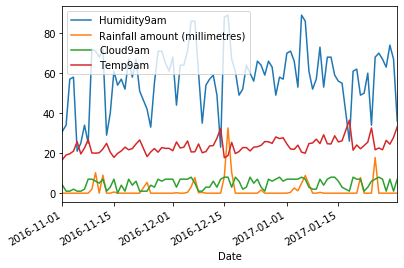

In [183]:
# visualising the data to find trends 

final_data.loc['2016-11':'2017-01'].plot.line(y = ['Humidity9am','Rainfall amount (millimetres)', 'Cloud9am', 'Temp9am']) 



Text(0.5, 1.0, 'frequency of rainfall amounts')

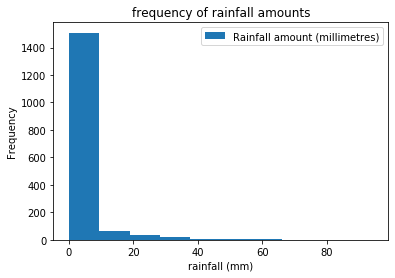

In [184]:
#Visualise data distributions

#Rain amount frequency using hist
ax = final_data.plot(kind= 'hist', y = 'Rainfall amount (millimetres)')
ax.set_xlabel("rainfall (mm)")
ax.set_title('frequency of rainfall amounts')

Text(0.5, 1.0, 'boxplot of rainfall')

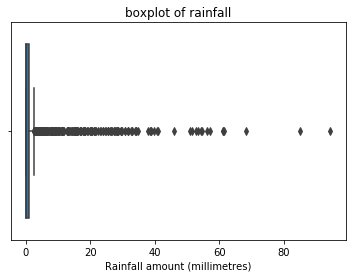

In [185]:
#Box plot to show the spread of the data
new_data = final_data['Rainfall amount (millimetres)']
ax = sns.boxplot(new_data)
ax.set_title('boxplot of rainfall')

We can see that there is a very high concentration of data points very low, indicating that a large percentage of rainfall is below 5mm or exactly 0. Plot also depicts that there is a large number of outliers, probably because our data is quite big.

In [186]:
#quick look at linear correlations between variables
final_data.corr()
None


## Linear regression model and RFE to find best features 

In [187]:
#Linear regression with RFE


feature_cols = np.array(['Evaporation','Sunshine','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm','Maximum temperature (Degree C)','Minimum temperature (Degree C)','Daily global solar exposure (MJ/m*m)','gust_dir_E','gust_dir_ENE','gust_dir_ESE','gust_dir_N','gust_dir_NE','gust_dir_NNE','gust_dir_NNW','gust_dir_NW','gust_dir_S','gust_dir_SE','gust_dir_SSE','gust_dir_SSW','gust_dir_SW','gust_dir_W','gust_dir_WNW','gust_dir_WSW','9am_wind_dir_E','9am_wind_dir_ENE','9am_wind_dir_ESE','9am_wind_dir_N','9am_wind_dir_NE','9am_wind_dir_NNE','9am_wind_dir_NNW','9am_wind_dir_NW','9am_wind_dir_S','9am_wind_dir_SE','9am_wind_dir_SSE','9am_wind_dir_SSW','9am_wind_dir_SW','9am_wind_dir_W','9am_wind_dir_WNW','9am_wind_dir_WSW','3pm_wind_dir_E','3pm_wind_dir_ENE','3pm_wind_dir_ESE','3pm_wind_dir_N','3pm_wind_dir_NE','3pm_wind_dir_NNE','3pm_wind_dir_NNW','3pm_wind_dir_NW','3pm_wind_dir_S','3pm_wind_dir_SE','3pm_wind_dir_SSE','3pm_wind_dir_SSW','3pm_wind_dir_SW','3pm_wind_dir_W','3pm_wind_dir_WNW','3pm_wind_dir_WSW'])
X = final_data[feature_cols]
y = final_data['Rainfall amount (millimetres)']

#finding the most relevant features
estimator = LinearRegression()
selector = RFE(estimator, 6)  # select 6 features for us
selector = selector.fit(X, y)


supp = selector.get_support()
print("Selected features:", feature_cols[supp])
print("Coeffs:", selector.estimator_.coef_)

# test the model
predicted = selector.predict(X)

#MSE, lower is better

print("MSE:", mean_squared_error(y, predicted))

# R2, higher is better 
print("R^2:", r2_score(y, predicted))



Selected features: ['gust_dir_SE' '9am_wind_dir_S' '9am_wind_dir_SE' '3pm_wind_dir_S'
 '3pm_wind_dir_SSW' '3pm_wind_dir_SW']
Coeffs: [ 5.26691836  3.8568247  10.09131981  3.43202774  4.18886157  3.83672466]
MSE: 62.25054607634233
R^2: 0.08839471598558868


#### Thoughts on model

We can see that the model has chosen the 6 variables that have the greatest affect on rainfall(mm). The model is favouring the southerly winds which tends to be accurate as typically when syndey is getting northerly winds they tend to be drier winds as they are coming from the heated interior of Australia. Sydney is located in what is called the subtropical ridge which moves above and below sydney throught the year. When the ridge moves below syndey in the late summer and autumn the winds typically become more easterly and from the tasman sea. These winds are generally a more moist wind bringing more rain in these periods.

However our measurements of accuracy of the model, MSE is relatively high and R2 is very low, indicating that the model fitted does not well suit the data, nor produce accurate predictions. (if we were to plug in x values)



## Predicting the amount of rainfall (exploring the data)

From using .corr() function (when looking for trends above), humidity and cloud variables provided the greatest correlation with rainfall in mm. With this knowledge we can now **explore** the accuracy of models that use these variables to predict the amount of rainfall.

In [188]:
# create X and y
feature_cols = ['Humidity9am']
X = final_data[feature_cols]
y = final_data['Rainfall amount (millimetres)'] 

#instantiate, fit
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [189]:
print("y = ", model.coef_, "* x + ", model.intercept_) 

y =  [0.17777174] * x +  -8.944683752950999


In [190]:
xmin = X.min()
ymin = model.coef_[0] * xmin + model.intercept_
xmax = X.max()
ymax = model.coef_[0] * xmax + model.intercept_


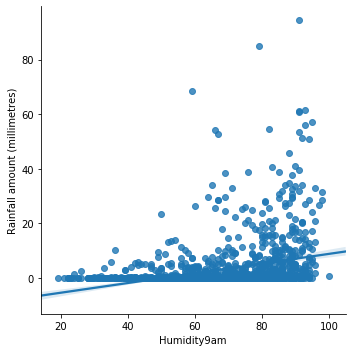

In [191]:
 sns.lmplot('Humidity9am', 'Rainfall amount (millimetres)', final_data, height=5)

In [192]:
#evaluating this model
predicted = model.predict(X)
print("MSE:", mean_squared_error(y, predicted))
print("R^2:", r2_score(y, predicted))


MSE: 60.98908147108104
R^2: 0.1068677716009252


#### Making our model better
if we also factor the cloud variable with humidity, our model may improve

In [193]:
# create X and y, add 2 more features to x
feature_cols = ['Humidity9am', 'Humidity3pm',"Cloud9am"]
X = final_data[feature_cols]
y = final_data['Rainfall amount (millimetres)'] 

#instantiate, fit
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [194]:
print("y = ", model.coef_, "* x + ", model.intercept_) 

y =  [0.10193932 0.06516373 0.39340354] * x +  -9.013050630801827


In [195]:
predicted = model.predict(X)
print("MSE:", mean_squared_error(y, predicted))
print("R^2:", r2_score(y, predicted))


MSE: 59.07589251001274
R^2: 0.13488476544526873


The value of the $R^{2}$ value shows that the model has improved a little bit from the previous model, but still it's not a good model yet.

### Visualising our results


Text(0, 0.5, 'rainfall (mm)')

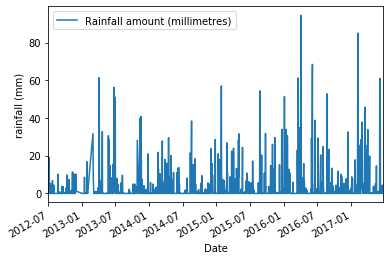

In [196]:
#plotting the real data of rainfall (mm)
ax2 = final_data.plot(kind = 'line', y = 'Rainfall amount (millimetres)')
ax2.set_ylabel("rainfall (mm)")


In [197]:
#new column in the frame to stored predicted rainfall
final_data['predicted'] = predicted

Text(0, 0.5, 'rainfall (mm)')

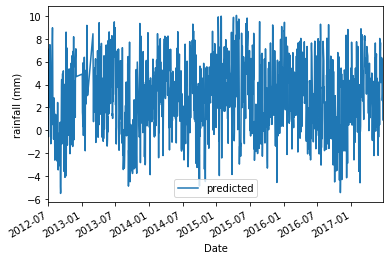

In [198]:
#plotting our predicted rainfall
ax3 =final_data.plot(kind = 'line', y = 'predicted')
ax3.set_ylabel("rainfall (mm)")


Note that predicted rain never goes beyond 10mm

Also, negative predictions should be considered as 0

### Results

Through fine tuning our model and changing the features it takes into account we were able to marginally improve upon its accuracy. Both the MSE and R2 are in better shape  after adding more features chosen through observation. 

However it is clear to see that our model is not accurate


## The effect of temperature on the occurrence of rainfall (exploring the data)

Even though our previous base model using RFE did not pick temp as a feature, it is often thought that temperature has a substantial effect on rainfall. This model will be based on temp.

In [199]:
# model for temp3pm vs  whether it rains or not

#make rainfall a categorical variable, eg rainfall = 1, no_rain = 0.

final_data['rain'] = (final_data['Rainfall amount (millimetres)'] > 0).astype('int64')
final_data['no_rain'] = (final_data['Rainfall amount (millimetres)'] == 0).astype('int64')


In [200]:
#sort by column
final_data['Temp3pm'].sort_values()
None

#### Logistic regression categorical rain vs temp3pm

In [201]:
#using logistic reg

feature_cols = ['Temp3pm']
X = final_data[feature_cols]
y = final_data['rain']
logreg = LogisticRegression()
logreg.fit(X, y)

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Text(0, 0.5, 'predicted rain')

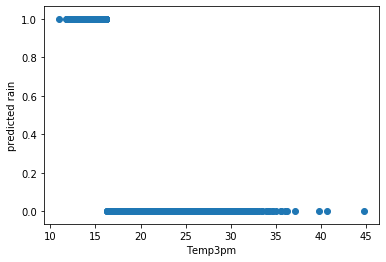

In [202]:
#predict and plot
predicted = logreg.predict(X)
plt.scatter(X, predicted)
plt.xlabel('Temp3pm');plt.ylabel('predicted rain')

In [203]:
print("Accuracy:", metrics.accuracy_score(y, predicted))

Accuracy: 0.6281041792852816


#### Visualising success of the logistic regression model

<function matplotlib.pyplot.show(*args, **kw)>

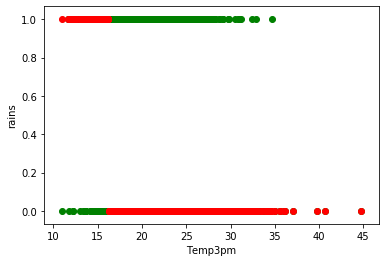

In [204]:
#visualising the success of our model

x = np.array(final_data['Temp3pm'])
y = np.array(final_data['rain'])


plt.scatter(x, y,color = 'green')
plt.scatter(x, predicted,color = 'red')
plt.xlabel('Temp3pm');plt.ylabel('rains')
plt.show

Green is the **data** plot of temperature and whether or not it rains

Red is temperature and our **predictions** of whether it will rain or not

#### Evaluating the logistic reg model

Numerically, our model received an accuracy score of 0.62... using the accuracy_score function. This informs us the accuracy of this model is low.

In the above figure, red is our logistic regression model predictions, whilst green is the actual data from the frame.
You can see that it is not very successful. The model (red) predicts that rainfall does not occur at all at temps above 17 deg celsius. 

Below is the probability prediction made by the same logistic model.

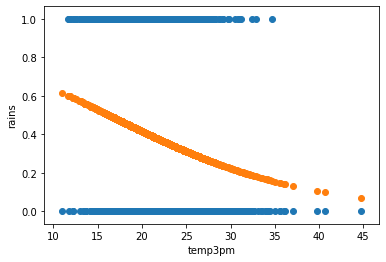

In [205]:
#Probability with logistic regression
probs = logreg.predict_proba(X)[:, 1] 
plt.scatter(X, y); plt.scatter(X, probs)
plt.xlabel('temp3pm');plt.ylabel( 'rains')
None

### Analysis of probability model

With the use of the logistic regression probability graph, one can see that the line maintains a linear form, showing that the colder the temp is (at 3pm), the more likely it will rain on that day. 

At temperatures >17 degrees C, it appears that the chance of rain is below 0.5.

< 17 degrees C, probability of rain is above 0.5.

##### The line of probability in this graph is too flat, indicating that probabilities are more vague than desired

## Heatmap of Total Daily Rainfall for each month:

Generating a heatmap to show the total rainfall each month

Reset the index and generate a new dataframe with date and rainfall:

In [206]:
from datetime import date
heatmap = rainfall_final.reset_index()
heatmap2 = heatmap[['Date', 'Rainfall amount (millimetres)']]

Restricting the date between January 1st 2013 and December 31st 2016 this is done because they have a full years worth of data.

In [207]:
# restrict to only complete years
heatmap2 = heatmap2.loc[(heatmap2['Date'] >= '2013-01-01')]   # for every month ( includes only 6 months for 2012 and 2017)
heatmap3 = heatmap2.loc[(heatmap2['Date'] <= '2016-12-31')]   # >= 2012-07-01 & <=2017-05-31

Convert to datetime month and datetime year

In [208]:
heatmap3['month'] = heatmap3['Date'].dt.month;
heatmap3['year'] = heatmap3['Date'].dt.year;

C:\Users\Mark\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Mark\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Pivot the dataframe to generate the sum of rainfall for each month:

In [209]:
df = pd.pivot_table(heatmap3[['year', 'month', 'Rainfall amount (millimetres)']], index=['year', 'month'], aggfunc=np.sum)

In [210]:
df2 = df.unstack(level=0)

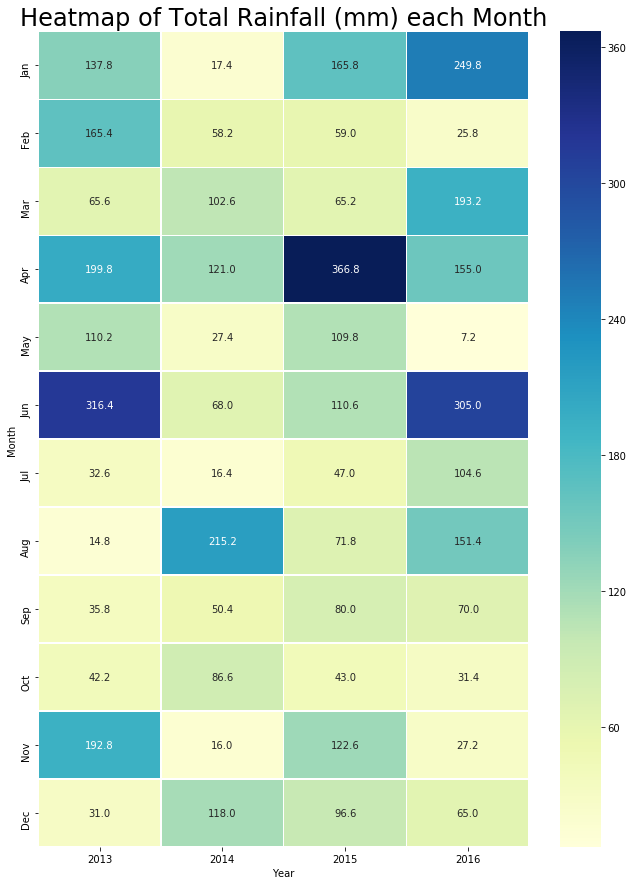

In [211]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year = ['2013', '2014', '2015', '2016']
f, ax = plt.subplots(figsize=(11, 15))
ax = sns.heatmap(df2, annot=True, fmt=".1f", linewidths=0.5, ax=ax, xticklabels = year, yticklabels = month, cmap="YlGnBu")
ax.axes.set_title("Heatmap of Total Rainfall (mm) each Month", fontsize=24, y=1.01)
ax.set(xlabel='Year', ylabel='Month');

The heatmap shows that April 2015 had the highest total rainfall (366.8mm), while May 2016 had the lowest total rainfall (7.2mm).

## Predicting whether it will rain:

If any issues viewing outputs, install the following:
* python-graphviz
* pydot

In [212]:
# libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data
from sklearn.neural_network import MLPClassifier

Begin by generating a new column in our dataset, "Rain today", whereby if rainfall is zero it takes a value of 0, and if rainfall is > 0 it takes a value of 1. 

In [213]:
# create a new column to determine whether it rained on that day (no rain = 0, rain = 1)
final_data['Rain today'] = [0 if x == 0.0 else 1 for x in final_data['Rainfall amount (millimetres)']]

Generating our X and y data and splitting it into training and testing sets:

In [214]:
feature_cols = np.array(['Evaporation','Sunshine','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm','Maximum temperature (Degree C)','Minimum temperature (Degree C)','Daily global solar exposure (MJ/m*m)','gust_dir_E','gust_dir_ENE','gust_dir_ESE','gust_dir_N','gust_dir_NE','gust_dir_NNE','gust_dir_NNW','gust_dir_NW','gust_dir_S','gust_dir_SE','gust_dir_SSE','gust_dir_SSW','gust_dir_SW','gust_dir_W','gust_dir_WNW','gust_dir_WSW','9am_wind_dir_E','9am_wind_dir_ENE','9am_wind_dir_ESE','9am_wind_dir_N','9am_wind_dir_NE','9am_wind_dir_NNE','9am_wind_dir_NNW','9am_wind_dir_NW','9am_wind_dir_S','9am_wind_dir_SE','9am_wind_dir_SSE','9am_wind_dir_SSW','9am_wind_dir_SW','9am_wind_dir_W','9am_wind_dir_WNW','9am_wind_dir_WSW','3pm_wind_dir_E','3pm_wind_dir_ENE','3pm_wind_dir_ESE','3pm_wind_dir_N','3pm_wind_dir_NE','3pm_wind_dir_NNE','3pm_wind_dir_NNW','3pm_wind_dir_NW','3pm_wind_dir_S','3pm_wind_dir_SE','3pm_wind_dir_SSE','3pm_wind_dir_SSW','3pm_wind_dir_SW','3pm_wind_dir_W','3pm_wind_dir_WNW','3pm_wind_dir_WSW'])
X = final_data[feature_cols]
y = final_data['Rain today']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.3, random_state = 0)

Looking at our training and testing data sets for X and y:

In [215]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

X_train shape: (1155, 64)
y_train shape: (1155,)


In [216]:
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_test shape: (496, 64)
y_test shape: (496,)


So our training set is made up of 1155 observations and our testing set is made up of 496 observations.
<br>
We will build models based on the training set and then test them using the testing set, looking at the accuracy of its predictions.

### Logistic Regression (base model):
Generate a base model for which comparisons can be made.

In [217]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_test)

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Results:

First we generate a confusion matrix which will show how our model trained on the training set will predict in the testing set:

Text(0.5, 15.0, 'Predicted outcome')

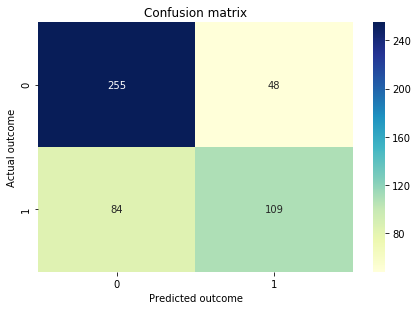

In [218]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_logreg)
cnf_matrix

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual outcome')
plt.xlabel('Predicted outcome')

This matrix shows the predicted outcome against the actual outcome, where no rain = 0, and rain = 1.

So...
From the 496 observations in the testing set, our logistic regression successfully predicted:
<br>
364/496 observations or 73.39% based on its training from the training set
<br>
<br>
The top right quadrant represents a false positive (Type 1 error), i.e. predicting it will rain and it doesnt
<br>
The bottom left quadrant represents a false negative (Type 2 error). i.e. predicting it wont rain and it does.

This can also be portrayed in the accuracy score:
<br>
Accuracy Score is the ratio of correctly predicted observation to the total observations.

In [219]:
#print('Accuracy: ', accuracy_score(y_test, y_pred_logreg))
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print('Accuracy: ', accuracy_logreg)

Accuracy:  0.7338709677419355


We also utilse F1 score to measure the success of our model:
<br>
F1 score is the weighted average of Precision and Recall.

In [220]:
#print('F1 score: ', f1_score(y_test, y_pred_logreg))
f1_score_logreg = f1_score(y_test, y_pred_logreg)
print('F1 score: ', f1_score_logreg)

F1 score:  0.6228571428571429


## Now we utilise different techniques to improve the baseline model:

### 1. K Nearest Neighbor

We look at a range of values for K (1-40) to see which produces the most accurate model:

In [221]:
neighbors = list(range(1,40))
error = []

Now we find the mean error for each value of k:

In [222]:
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
error

[0.33669354838709675,
 0.3185483870967742,
 0.3165322580645161,
 0.2903225806451613,
 0.2842741935483871,
 0.29435483870967744,
 0.2762096774193548,
 0.2782258064516129,
 0.2661290322580645,
 0.2782258064516129,
 0.26814516129032256,
 0.2721774193548387,
 0.26814516129032256,
 0.27419354838709675,
 0.2661290322580645,
 0.2782258064516129,
 0.27419354838709675,
 0.28830645161290325,
 0.2762096774193548,
 0.27419354838709675,
 0.2701612903225806,
 0.28225806451612906,
 0.26411290322580644,
 0.2762096774193548,
 0.26814516129032256,
 0.27419354838709675,
 0.27419354838709675,
 0.27419354838709675,
 0.2762096774193548,
 0.27419354838709675,
 0.2701612903225806,
 0.28024193548387094,
 0.27419354838709675,
 0.2862903225806452,
 0.2721774193548387,
 0.2862903225806452,
 0.2762096774193548,
 0.28024193548387094,
 0.27419354838709675]

Plotting these errors against the value of K we can produce the following plot:

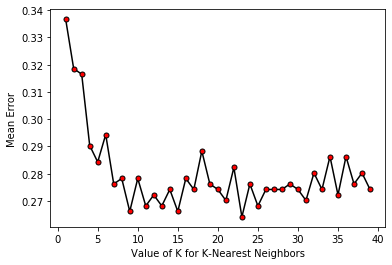

In [223]:
plt.plot(neighbors, error, color = 'black', marker = 'o', markerfacecolor = 'red', markersize = 5)
plt.xlabel('Value of K for K-Nearest Neighbors')
plt.ylabel('Mean Error')
plt.show()

Looking for the smallest mean error, we see that this occurs when k is set to 23

Conducting K Nearest Neighbor with k=23:

In [224]:
k = 23 # number of neighbors
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

Text(0.5, 15.0, 'Predicted outcome')

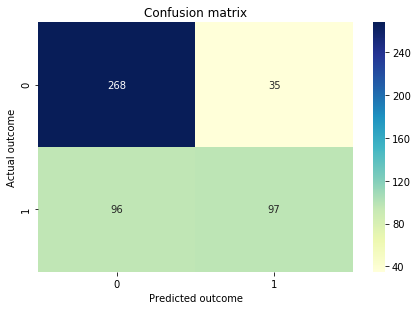

In [225]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
cnf_matrix

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual outcome')
plt.xlabel('Predicted outcome')

Here we can see that the model successfully predicts whether it will rain in:
<br>
365/496 observations or 73.59%

Looking at the accuracy score and F1 score for the 23 nearest neighbors model:

In [226]:
#print('Accuracy: ', accuracy_score(y_test, y_pred_knn))
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print('Accuracy: ', accuracy_knn)
#print('F1 score: ', f1_score(y_test, y_pred_knn))
f1_score_knn = f1_score(y_test, y_pred_knn)
print('F1 score: ', f1_score_knn)

Accuracy:  0.7358870967741935
F1 score:  0.5969230769230769


### 2. Decision Trees

Generating a decision tree model:
<br>
We use max depth = 3 beacuse it provides a good basis for analysis. If the max depth is too low, the model will be underfitted, if we use a high max depth, the model will be overfitted.
<br>
This is because the decision tree is based upon the training set, so when it is applied to the testing set, if the model is over/underfitted it wont be a good prediction model

In [227]:
dt = DecisionTreeClassifier(random_state=0, max_depth=3) # set the max depth of the decision tree to 3
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

What our Decision Tree looks like: (max depth = 3)

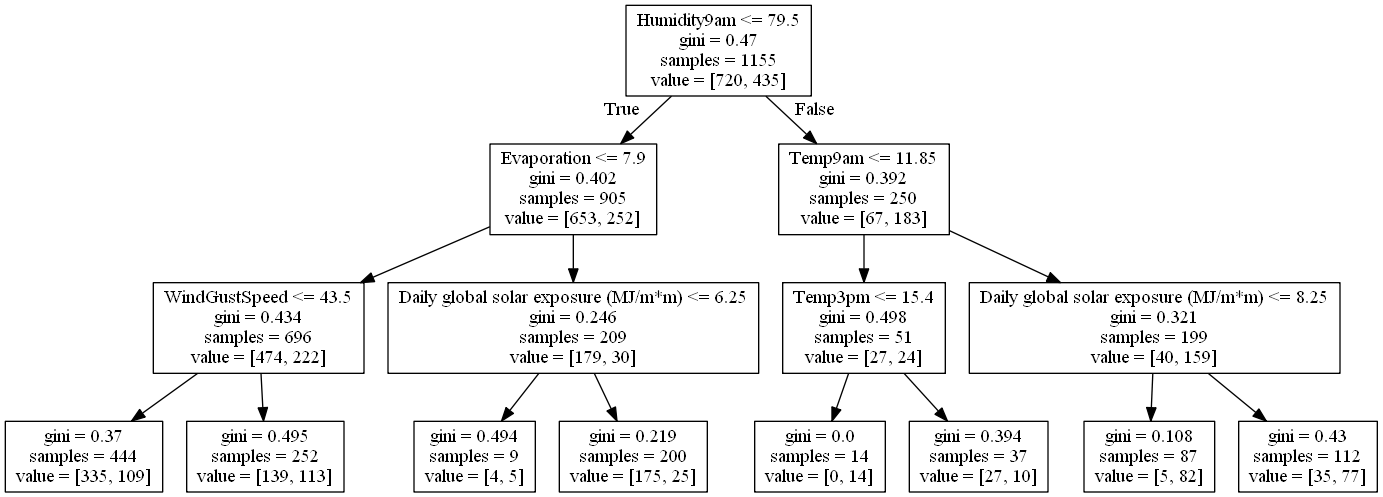

In [228]:
feat_names = X.columns
targ_names = ['Rain','No Rain']

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, feature_names=feat_names)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Text(0.5, 15.0, 'Predicted outcome')

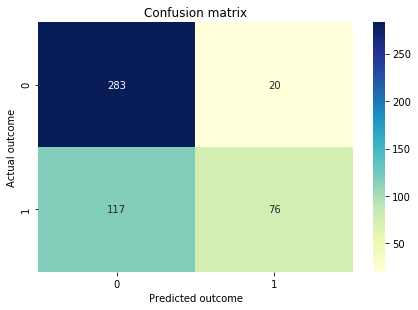

In [229]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_dt)
cnf_matrix

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual outcome')
plt.xlabel('Predicted outcome')

Here we can see that the model successfully predicts whether it will rain in:
<br>
359/496 observations or 72.38%

In [230]:
#print('Accuracy: ', accuracy_score(y_test, y_pred_dt))
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print('Accuracy: ', accuracy_dt)
#print('F1 score: ', f1_score(y_test, y_pred_dt))
f1_score_dt = f1_score(y_test, y_pred_dt)
print('F1 score: ', f1_score_dt)

Accuracy:  0.7237903225806451
F1 score:  0.5259515570934256


### 3. Neural Networks

First we generate a Neural Netork with random state = 0 and default parameters, later we will look at the effects of changing these other parameters on the accuracy of our model.

In [231]:
mlp = MLPClassifier(random_state=0)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

Text(0.5, 15.0, 'Predicted outcome')

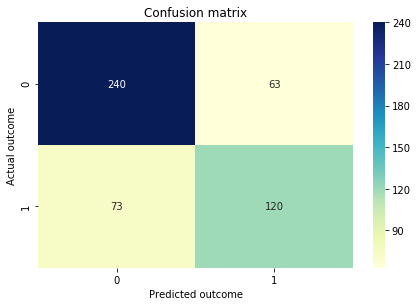

In [232]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual outcome')
plt.xlabel('Predicted outcome')

Here we can see that the model successfully predicts whether it will rain in:
<br>
360/496 observations or 72.58%

In [233]:
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

Accuracy:  0.7258064516129032
F1 score:  0.6382978723404256


Utilising the different parameters in MLPClassifier:

1. Changing the number of iterations:

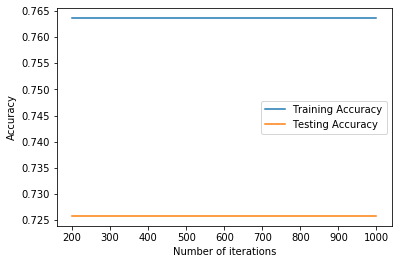

In [234]:
training_accuracy = []
testing_accuracy = []
iterations = range(200, 1001, 200)

for i in iterations:
    
    training_accuracy.append(mlp.score(X_train, y_train))
    testing_accuracy.append(mlp.score(X_test, y_test))
    
plt.plot(iterations, training_accuracy, label = "Training Accuracy")
plt.plot(iterations, testing_accuracy, label = "Testing Accuracy")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Here we can see the accuracy of the model doesnt change when we change the number of iterations

2. Changing the number of hidden units:

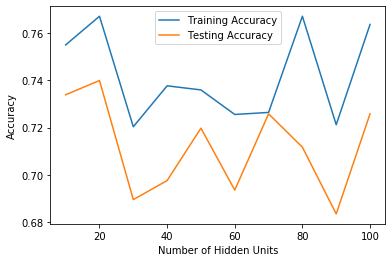

In [235]:
training_accuracy = []
testing_accuracy = []
hidden_units = range(10, 101, 10)

for i in hidden_units:
    mlp = MLPClassifier(hidden_layer_sizes = [i], random_state = 0, max_iter=1000)
    mlp.fit(X_train, y_train)
    training_accuracy.append(mlp.score(X_train, y_train))
    testing_accuracy.append(mlp.score(X_test, y_test))
    
plt.plot(hidden_units, training_accuracy, label = "Training Accuracy")
plt.plot(hidden_units, testing_accuracy, label = "Testing Accuracy")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Accuracy for the testing set is maximised when there are 20 hidden units.

3. Changing the solver used:

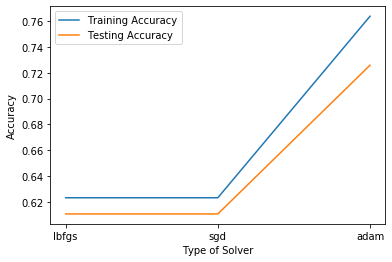

In [236]:
training_accuracy = []
testing_accuracy = []
solvers = ['lbfgs','sgd', 'adam']

for i in solvers:
    mlp = MLPClassifier(solver = i, random_state = 0)
    mlp.fit(X_train, y_train)
    training_accuracy.append(mlp.score(X_train, y_train))
    testing_accuracy.append(mlp.score(X_test, y_test))
    
plt.plot(solvers, training_accuracy, label = "Training Accuracy")
plt.plot(solvers, testing_accuracy, label = "Testing Accuracy")
plt.xlabel("Type of Solver")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

'adam' is the solver that provides the greatest accuracy for the testing set.

So now we build a new Neural Network, changing the parameters to maximise accuracy:

In [237]:
mlp = MLPClassifier(random_state=0, max_iter=1000, hidden_layer_sizes=20, solver='adam')
mlp.fit(X_train, y_train)
y_pred_nn = mlp.predict(X_test)

Text(0.5, 15.0, 'Predicted outcome')

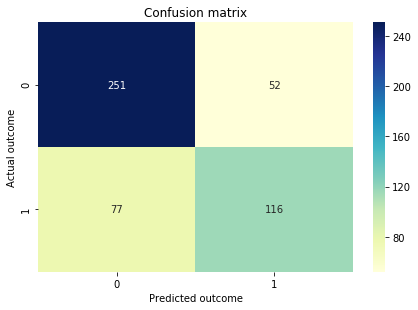

In [238]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_nn)
cnf_matrix


class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual outcome')
plt.xlabel('Predicted outcome')

Here we can see that the model successfully predicts whether it will rain in:
<br>
367/496 observations or 73.99%

In [239]:
#print('Accuracy: ', accuracy_score(y_test, y_pred_nn))
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print('Accuracy: ', accuracy_nn)
#print('F1 score: ', f1_score(y_test, y_pred_nn))
f1_score_nn = f1_score(y_test, y_pred_nn)
print('F1 score: ', f1_score_nn)

Accuracy:  0.7399193548387096
F1 score:  0.6426592797783933


### Results from these 4 models:

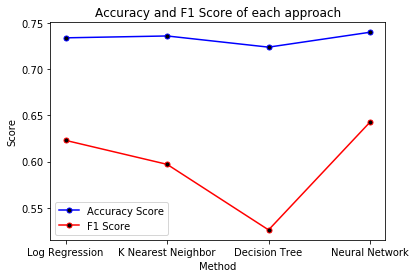

In [240]:
method = ['Log Regression', 'K Nearest Neighbor', 'Decision Tree', 'Neural Network']
accuracy = [accuracy_logreg, accuracy_knn, accuracy_dt, accuracy_nn]
f1_score = [f1_score_logreg, f1_score_knn, f1_score_dt, f1_score_nn]
plt.plot(method, accuracy, color = 'blue', label = "Accuracy Score", marker = 'o', markerfacecolor = 'black', markersize = 5)
plt.plot(method, f1_score, color = 'red', label = "F1 Score", marker = 'o', markerfacecolor = 'black', markersize = 5)
plt.xlabel("Method")
plt.ylabel("Score")
plt.title("Accuracy and F1 Score of each approach")
plt.legend()
plt.show()

**Logistic regression (base model):**
* Accuracy Score = 0.7338709677419355
* F1 Score = 0.6228571428571429

**K Nearest Neighbor:**
* Accuracy Score = 0.7358870967741935
* F1 Score = 0.5969230769230769

**Decision Tree:**
* Accuracy Score = 0.7237903225806451
* F1 Score = 0.5259515570934256

**Neural Network:**
* Accuracy Score = 0.7399193548387096
* F1 Score = 0.6426592797783933

So training our model using a neural network produced the greatest accuracy and F1 score when forming predictions on the testing set.

## Summary and Conclusion

At first we started our project by cleaning the data and joining datasets to get the desired data. 
In the analysis section our job was to imrove the value of $R^{2}$ .

For rainfall prediction, our  

*logistic regression* shows accuracy of 73.39%.  

*KNN Model* shows accuracy of 73.59%  

*Decision Tree* shows accuracy of 72.38%  

*Neural Network* shoes accuracy of 73.99%  


So training our model using a neural network produced the greatest accuracy and F1 score when forming predictions on the testing set.
